In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import glob
import h5py
import seaborn as sns
import librosa
from itertools import chain
import matplotlib.pyplot as plt
from lib.uti import get_f_name, list_duplicates
from lib.fs import FeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from catboost import CatBoostClassifier
np.set_printoptions(suppress=True)
data = {'ComParE':'./FE/ComParE.csv','eGeMAPS':'./FE/eGeMAPS.csv','GeMAPS':'./FE/GeMAPS.csv','emobase':'./FE/emobase.csv'}
data2 = {'ComParE':'./FE/ComParE_v3.csv','eGeMAPS':'./FE/eGeMAPS_v3.csv','emobase':'./FE/emobase_v3.csv'}
data3 = {'ComParE':'./FE/ComParE_v4.csv','eGeMAPS':'./FE/eGeMAPS_v4.csv','emobase':'./FE/emobase_v4.csv'}
annotation = './data/annotation.csv'
annot = pd.read_csv(annotation)
def get_duration(s):
    return float(s.split(':')[-1])
def get_id(s):
    return s.split('/')[-2]
def get_id2(s):
    return s.split('/')[-2].split('-')[0]
def get_seg_id(s):
    return s.split('/')[-1]

def get_column_by_id(df, id, col=['entryage','sex']):
    df = df[df.id.isin(id)]
    return dict(zip(df.id.values, df[col].values)) 

def get_age_gender(r, dic, flag):
    id = r.split('/')[-2].split('-')[0]
    return dic[int(id)][flag]

tem_f = get_f_name('./data/audio/Pitt/Control/')
tem_f_c = [i.split('.')[0] for i in tem_f]
id_c = list(dict.fromkeys(tem_f_c))
tem_f = get_f_name('./data/audio/Pitt/Dementia/')
tem_f_ad = [i.split('.')[0] for i in tem_f]
id_ad = list(dict.fromkeys(tem_f_ad))

processed_df_path = './FE/ML_s/'
os.makedirs(processed_df_path,exist_ok=True)

In [14]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,recall_score,precision_score,accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold

In [198]:
feature_set_name = ['eGeMAPS','emobase', 'ComParE']
feature_set = feature_set_name[1]

In [45]:
df = pd.read_csv(data2[feature_set])

In [46]:
df.columns

Index(['file', 'start', 'end', 'F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_s

eGeMAPS - feature num: 88

emobase - feature num: 988

ComParE - feature num: 6373

In [892]:
df.isnull().sum(axis = 0).sort_values()

file                         0
mfcc_sma_de[7]_maxPos        0
mfcc_sma_de[7]_minPos        0
mfcc_sma_de[7]_amean         0
mfcc_sma_de[7]_linregc1      0
                            ..
lspFreq_sma[3]_linregerrQ    0
lspFreq_sma[3]_stddev        0
lspFreq_sma[3]_skewness      0
lspFreq_sma[3]_quartile1     0
F0env_sma_de_iqr1-3          0
Length: 991, dtype: int64

In [893]:
print(len(df.iloc[0][3:]))

988


In [894]:
cor_matrix = df[df.columns[3:]].corr(method='pearson').abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
drop_col = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(len(drop_col))
df_ = df.drop(columns=drop_col)

325


In [898]:
#df['age'] = df['file'].apply(lambda r: get_age_gender(r,age_gender_by_id,0))
#df['sex'] = df['file'].apply(lambda r: get_age_gender(r,age_gender_by_id,1))
df_['duration'] = df_['end'].apply(get_duration)

In [902]:
corr_with_dur = df_[df_.columns[3:]].corr()['duration'][:-1]

In [903]:
corr_with_dur

pcm_intensity_sma_max       0.082903
pcm_intensity_sma_min      -0.039087
pcm_intensity_sma_maxPos    0.584647
pcm_intensity_sma_minPos    0.498445
pcm_intensity_sma_amean    -0.074018
                              ...   
F0env_sma_de_skewness      -0.283244
F0env_sma_de_quartile1     -0.230960
F0env_sma_de_quartile3     -0.028791
F0env_sma_de_iqr1-2         0.251554
F0env_sma_de_iqr2-3        -0.001264
Name: duration, Length: 663, dtype: float64

In [904]:
col_select = corr_with_dur[abs(corr_with_dur.values)>0.3]

In [905]:
col_select 

pcm_intensity_sma_maxPos     0.584647
pcm_intensity_sma_minPos     0.498445
pcm_loudness_sma_minPos      0.486064
pcm_loudness_sma_linregc2   -0.378185
mfcc_sma[1]_maxPos           0.630986
                               ...   
F0_sma_de_minPos             0.572313
F0env_sma_de_min            -0.412513
F0env_sma_de_minPos          0.633045
F0env_sma_de_linregc2       -0.584943
F0env_sma_de_linregerrQ     -0.307077
Name: duration, Length: 164, dtype: float64

In [906]:
df_ = df_.drop(columns=[i for i,_ in col_select.items()])

In [907]:
len(df_.columns)

503

In [908]:
df_.to_csv(processed_df_path+feature_set+'.csv',index=False)

load selected features after correlation check

clustering

In [199]:
df = pd.read_csv(processed_df_path+feature_set+'.csv')
df_main = df.iloc[:,3:-1]
X = df_main.to_numpy()

In [200]:
X = StandardScaler().fit_transform(X)

In [201]:
def label(r, id_ad):
    if r.split('/')[-2] in id_ad:
        return 1
    return 0
y = df.file.apply(lambda r: label(r, id_ad))

In [7]:
model =  CatBoostClassifier(iterations=150,
                              depth=9,
                              learning_rate=0.1,
                              bootstrap_type=['MVS','Bayesian'][1],
                              loss_function=['Logloss','CrossEntropy','MultiClass'][0],
                              use_best_model = True,
                              eval_metric = ['Logloss','CrossEntropy'][0],
                              verbose=False)
fs = FeatureSelector(model =model ,data = df_main, labels = y)

In [10]:
fs.identify_collinear(correlation_threshold=0.975)

0 features with a correlation magnitude greater than 0.97.



In [8]:
fs.identify_zero_importance(task ='classification', eval_metric = 'auc', n_iterations = 10, early_stopping = False)

Training Gradient Boosting Model


66 features with zero importance after one-hot encoding.



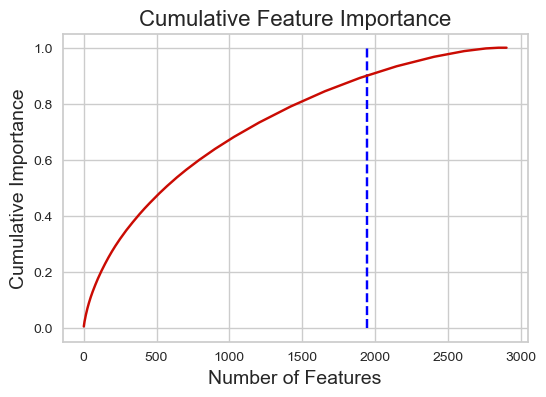

1943 features required for 0.90 of cumulative importance


In [10]:
fs.plot_feature_importances(threshold = 0.9, plot_n = 50)

In [11]:
fs.identify_low_importance(cumulative_importance = 0.8)

1462 features required for cumulative importance of 0.80 after one hot encoding.
1440 features do not contribute to cumulative importance of 0.80.



In [13]:
col=fs.feature_importances.feature[:100].values

In [ ]:
from yellowbrick.model_selection import RFECV
cv = StratifiedKFold(5)
model =  RandomForestClassifier(random_state=1,max_depth=20,n_estimators=200)
visualizer = RFECV(model, cv=cv,step= 0.5, scoring='f1_weighted')
visualizer.fit(X, y)        
visualizer.show()

In [ ]:
from yellowbrick.features import Rank2D
visualizer = Rank2D(algorithm='pearson',size=(1000,1000))
visualizer.fit(X, y)        
visualizer.transform(X)       
visualizer.show()  

In [531]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
X_tr_sel,X_t_sel,y_tr_sel,y_t_sel = train_test_split(X,y,test_size=0.3)

top_k = 100
X_indices = np.arange(X.shape[-1])
selector = SelectKBest(f_classif, k=top_k)
selector.fit(X_tr_sel, y_tr_sel)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

In [532]:
tem = df.iloc[:,3:-1]
columns = tem.columns[selector.get_support()].values
scores = scores[selector.get_support()]
top_sel = dict(zip(columns,scores))
top_sel = dict(sorted(top_sel.items(), key=lambda item: item[1], reverse=False))

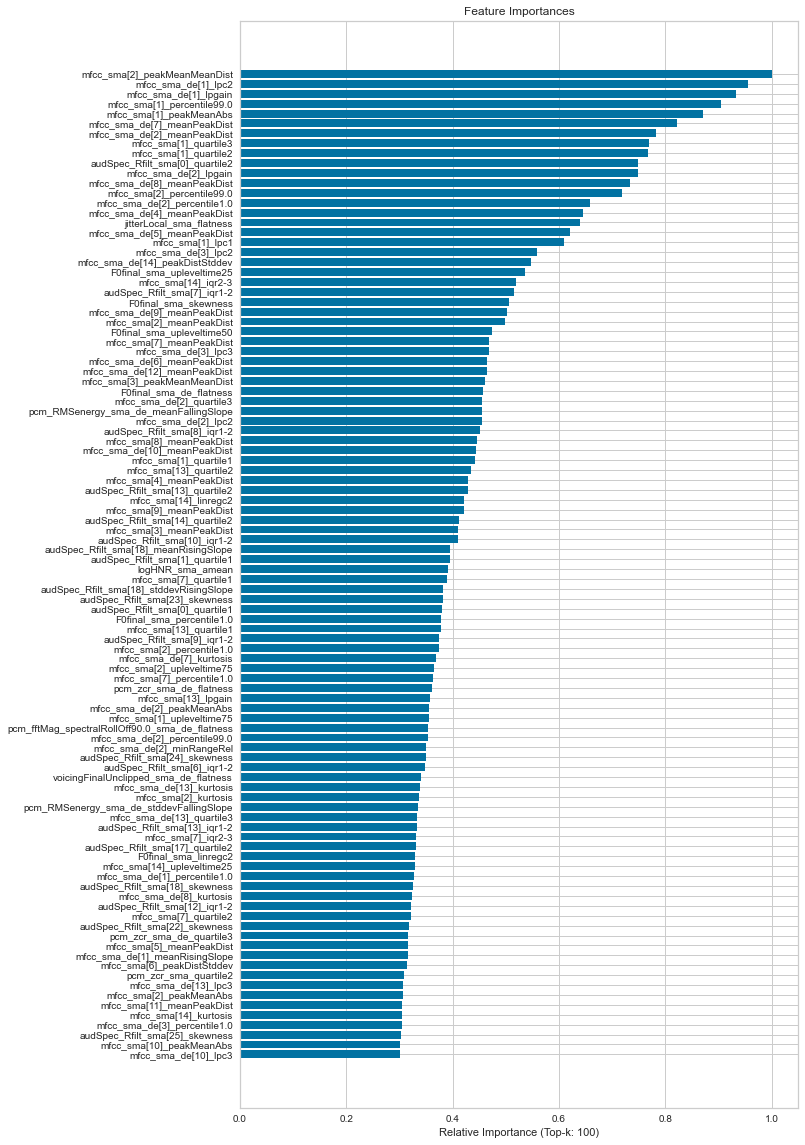

In [533]:
%matplotlib inline
plt.figure(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(scores)), list(top_sel.values()), color='b', align='center')
plt.yticks(range(len(scores)), list(top_sel.keys()))
plt.xlabel('Relative Importance (Top-k: {})'.format(len(scores)))
plt.show()

In [626]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(n_components=100,svd_solver='fullsvd')
pca.fit(X)
X = pca.transform(X)

In [252]:
tem = np.cumsum(pca.explained_variance_ratio_) 
len(tem[tem < 0.9])

500

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

model = LGBMClassifier(n_estimators=500,
                            boosting_type= 'gbdt',
                            num_leaves=100,
                            max_depth=30,
                            learning_rate=0.1,
                            min_child_samples=80,
                            random_state=100,
                            importance_type= 'split',
                            n_jobs=-1)
model = CatBoostClassifier(iterations=200,
                            depth=10,
                            learning_rate=0.1,
                            bootstrap_type=['MVS','Bayesian'][1],
                            loss_function=['Logloss','CrossEntropy','MultiClass'][0],
                            verbose=False)
model.fit(X, y.values)
model.best_score_

In [191]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
X_tr_sel,X_t_sel,y_tr_sel,y_t_sel = train_test_split(X,y,test_size=0.3)
sel.fit(X_tr_sel, y_tr_sel)

sel.get_support()
selected_feat= df.iloc[:,3:-1].columns[(sel.get_support())]
len(selected_feat)

197

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model =  RandomForestClassifier(random_state=1,max_depth=20,n_estimators=2000)
model.fit(X, y.values)

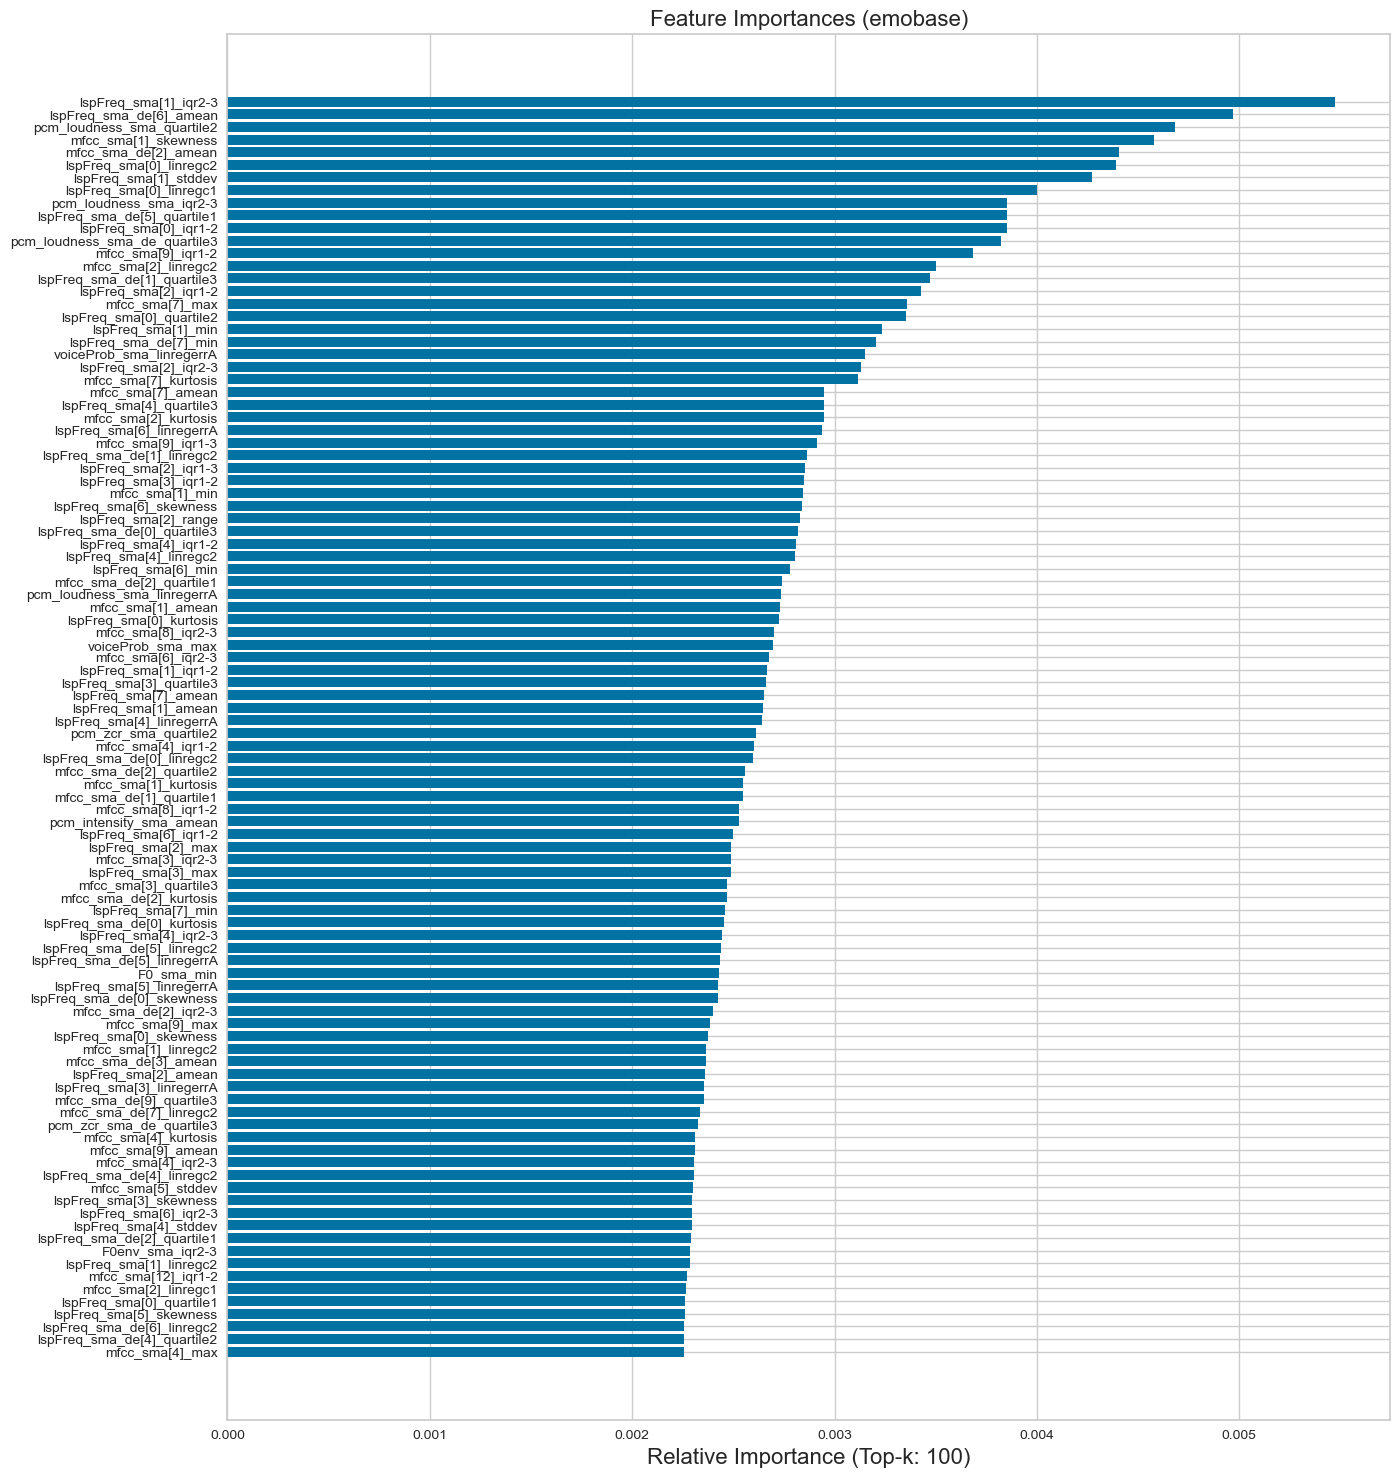

In [204]:
top_k = 100
if X.shape[1]< top_k:
    top_k = X.shape[1]
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-top_k:] 
plt.figure(figsize=(15, 18))
plt.title(f'Feature Importances ({feature_set})')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance (Top-k: {})'.format(top_k))
plt.show()

In [603]:
set(top_sel.keys()).intersection(set([features[i] for i in indices]))

{'F0final_sma_skewness',
 'jitterLocal_sma_quartile1',
 'mfcc_sma[14]_quartile1',
 'mfcc_sma[2]_meanPeakDist',
 'mfcc_sma[7]_quartile2',
 'mfcc_sma_de[1]_meanFallingSlope',
 'mfcc_sma_de[2]_quartile1',
 'pcm_zcr_sma_quartile2'}

In [34]:
X_select = X[...,sorted(indices)]

In [14]:
df_sel = df_main[col]
X_select = df_sel.to_numpy()

In [534]:
X_select = selector.transform(X)

In [320]:
X_select.shape

(4297, 100)

In [328]:
X_select = X

K-Means

In [329]:
k = 40
#X_select = StandardScaler().fit_transform(X_select)
kmeans = KMeans(n_clusters=k,
                init='k-means++',
                random_state=0, 
                tol = 1e-4,
                max_iter=300)

In [467]:
from lib.spcluster import SphericalKMeans
kmeans = SphericalKMeans(n_clusters=40)


In [469]:
kmeans.fit(X_select)
cluster_index = kmeans.labels_

In [33]:
# Import the KElbowVisualizer method 
visualizer = KElbowVisualizer(kmeans, k=(20,60), metric='silhouette', timings=False)
visualizer.fit(X_select)    
visualizer.poof()

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [330]:
visualizer = KElbowVisualizer(kmeans, k=(20,60),timings=False)
visualizer.fit(X_select)        # Fit the data to the visualizer
visualizer.show()

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

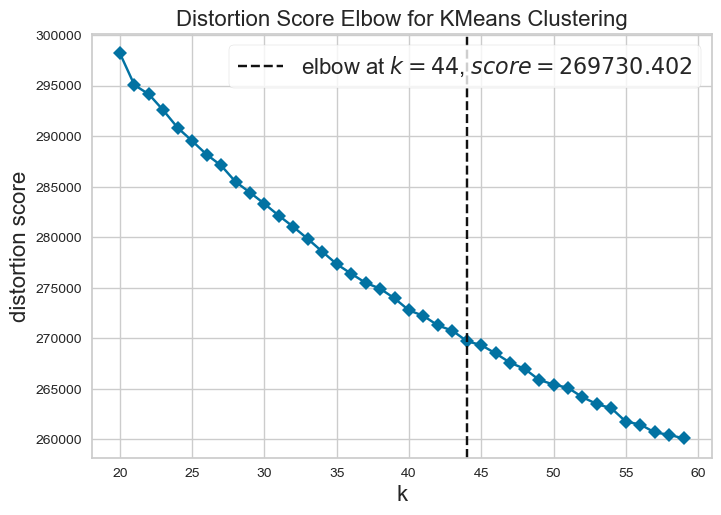

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [321]:
visualizer = KElbowVisualizer(kmeans, k=(20,60),timings=False)
visualizer.fit(X_select)        # Fit the data to the visualizer
visualizer.show()

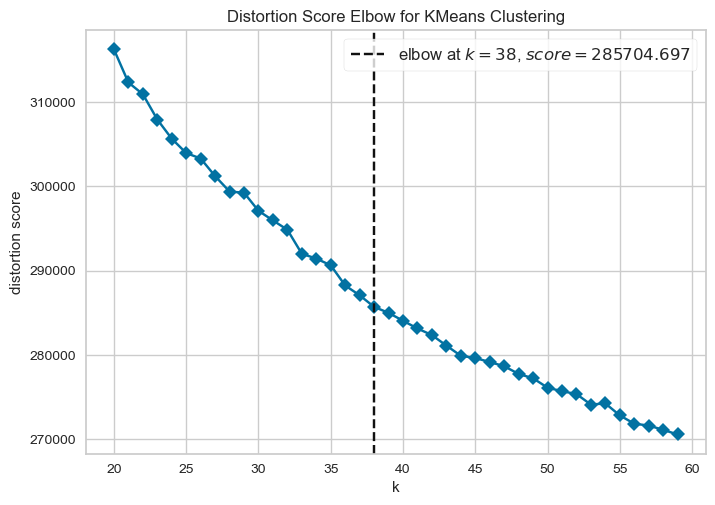

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
visualizer = KElbowVisualizer(kmeans, k=(20,60),timings=False)
visualizer.fit(X_select)        # Fit the data to the visualizer
visualizer.show()

SOM

In [878]:
from minisom import MiniSom   
som_d = (5,4)
k = som_d[0] * som_d[1] + 1

som = MiniSom(som_d[0], som_d[1], X_select.shape[1], 
              sigma=0.1, learning_rate=.01,
              neighborhood_function=['gaussian','bubble'][0], 
              activation_distance=['cosine','euclidean'][1],
              random_seed=10)

som.train(X_select, 10000, verbose=True)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X_select]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_d )

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 6.56073455892222


In [854]:
max(cluster_index)
k

26

In [611]:
winner_coordinates[1]

34

In [472]:
centers = kmeans.cluster_centers_
import matplotlib.pyplot as plt
plt.scatter(X_select[:, 6], X_select[:, 3] ,s=3, cmap='viridis')

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20, alpha=0.5)
plt.show()

In [642]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1],c=winner_coordinates[1] ,s=3, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20, alpha=0.5)

In [474]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

In [480]:
print(cluster_index)

[19 19 19 ... 19 19 19]


In [475]:
weights.shape

(10, 5, 40)

In [35]:
from scipy.spatial.distance import euclidean,cosine,mahalanobis
df_id = df.file.apply(get_id)
def cluster_feature_rep(cluster_index,k):
    hist = np.histogram(cluster_index,bins=np.arange(k+1))[0]
    hist = hist/np.sum(hist)
    return hist

def seg_duration_rep(cluster_index, duration, k):
    d = list_duplicates(cluster_index)
    hist_d = np.zeros(k)
    for idx,items in d:
        hist_d[idx] = np.sum(duration[items])
    hist_d = hist_d/np.sum(hist_d)
    return hist_d 

def cal_distance(X_select,seg_with_id,k):
    sum_ = np.zeros(k)
    for idx, i in enumerate(seg_with_id[1]):
        c = cluster_index[seg_with_id[1]][idx]
        u = kmeans.cluster_centers_[c]
        
        v = X_select[seg_with_id[1][idx]]
        sum_[c] = sum_[c] + (euclidean(u,v))
    # for idx,i in enumerate(np.histogram(cluster_index[seg_with_id[1]],bins=np.arange(k+1))[0]):
    #     if i != 0: sum_[idx] = sum_[idx]/i
    return sum_/ sum(sum_)

ad_dir = './processed_data/Pitt/AD/par_audio/norm3'
control_dir = './processed_data/Pitt/Control/par_audio/norm3'

def first_d(seg_id):
    f_n = f'{seg_id}_norm.wav'
    if f_n in get_f_name(ad_dir):
        y, sr = librosa.load(os.path.join(ad_dir,f_n))
    else: y, sr = librosa.load(os.path.join(control_dir,f_n))

    diff = y[1:] - y[:-1]
    print(y/y.shape[0])
    return np.array((diff.mean() , diff.std()))

ids = df['file'].apply(get_id2).values.astype(int)
age_gender_by_id = get_column_by_id(annot ,ids)

In [36]:
from lib.spcluster import SphericalKMeans
save_path = './data/data_ml/{}_2'.format(feature_set)
os.makedirs(save_path,exist_ok=True)
print(save_path)
X_select = StandardScaler().fit_transform(X_select)

for k in [10,20,30,40,50,60,70,80,90]:
    
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    random_state=0, 
                    tol = 1e-4,
                    max_iter=1000)
    
    # #kmeans = SphericalKMeans(n_clusters=k,max_iter=100) 
    kmeans.fit(X_select)
    cluster_index = kmeans.labels_  


    with h5py.File(save_path+'/dataset_{}.h5'.format(k), 'w') as f:
        f.create_dataset('X', (len(set(df_id.values)), 2*k+2))
        f.create_dataset('y', (len(set(df_id.values)),1))

    t = list_duplicates(df_id)
    cluster_index = cluster_index
    id_list = []
    with h5py.File(save_path+'/dataset_{}.h5'.format(k), 'r+') as f:
        for i in range(len(set(df_id.values))):
            
            seg_with_id = next(t)
            duration = df.iloc[seg_with_id[1],-1].values
            fe1 = cluster_feature_rep(cluster_index[seg_with_id[1]],k=k)
            fe2 = seg_duration_rep(cluster_index[seg_with_id[1]],duration, k=k)
            dis = cal_distance(X_select,seg_with_id,k)
            age_gender = age_gender_by_id[int(seg_with_id[0].split('-')[0])]
            
            feature_vector = np.concatenate([dis,fe2,age_gender])
            f['X'][i] = feature_vector
            f['y'][i] = 1 if seg_with_id[0] in id_ad else 0
            id_list.append(seg_with_id[0])
    with open(save_path+'/id_list_{}.txt'.format(feature_set),'w') as f:
        for i in id_list:f.write(i + ' ')

./data/data_ml/ComParE_2


Evaluation

In [162]:
clfs = {
    'SVM-linear':SVC(kernel="linear", C=0.1,probability=True),
    'SVM-rbf':SVC(kernel='rbf', gamma='scale',C=1,decision_function_shape ='ovt',probability=True),
    #'GP':GaussianProcessClassifier(1.0 * RBF(1.0)),
    'DT': DecisionTreeClassifier(max_depth=20,criterion='gini'),
    'RF':RandomForestClassifier(max_depth=20, n_estimators=500),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LDA': LinearDiscriminantAnalysis(),
    'MLP':MLPClassifier(activation='relu',
                        batch_size = 'auto',
                        shuffle=True,
                        hidden_layer_sizes=256,
                        learning_rate_init=0.01,
                        nesterovs_momentum=True,
                        validation_fraction = 0.2,
                        solver='adam', max_iter=1000,
                        early_stopping=False),

    'cat': CatBoostClassifier(iterations=150,
                              depth=9,
                              learning_rate=0.1,
                              bootstrap_type=['MVS','Bayesian'][1],
                              loss_function=['Logloss','CrossEntropy','MultiClass'][0],
                              use_best_model = True,
                              eval_metric = ['Logloss','CrossEntropy'][0],
                              verbose=False)
    }
   

In [331]:
      
selected_id = np.load('./data/selected_id3.npy') 

selected_id = np.delete(selected_id, np.argwhere(selected_id == 172))
t = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id]

In [16]:
def train_loop(clf_type, save_path, clfs, df_res,feature_set,k,times):
    skf = KFold(n_splits = 4, shuffle=True)

    with open(save_path+'/id_list_{}.txt'.format(feature_set),'r') as f:
        id_list = f.readlines()
        id_list = id_list[0].split(' ')
        id_list.remove('') 
        
    selected_id = np.load('./data/selected_id3.npy') 
    #print('feature set name: {}'.format(feature_set), end='\n\n')
    selected_id = np.delete(selected_id, np.argwhere(selected_id == 172))
    y_pre_res = []
    y_pre_proba_res = []
    id_list_pre = []
    y_true_ = []

    for idx, (tr_idx, t_idx) in enumerate(skf.split(selected_id)):
        
        selected_idx_tr = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id[tr_idx]]
        selected_idx_t  = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id[t_idx]]
        
        X_train, y_train = X_[selected_idx_tr], y_[selected_idx_tr].flatten()
        X_test, y_test   = X_[selected_idx_t],  y_[selected_idx_t].flatten()
        
        id_list_pre.extend([id_list[i] for i in selected_idx_t])
        y_true_.extend([y_[i] for i in selected_idx_t])

        if clf_type == 'cat':
            clf = clfs[clf_type]
            X_train = StandardScaler().fit_transform(X_train)
            X_test = StandardScaler().fit_transform(X_test)
            clf.fit(X_train,y_train, eval_set=Pool(X_test,y_test), verbose=False)
        else :
            clf = make_pipeline(StandardScaler(),PCA(10) ,clfs[clf_type])   
            clf.fit(X_train, y_train)
        
        y_pre = clf.predict(X_test)
        y_pre_proba = clf.predict_proba(X_test)
        y_pre_res.extend(y_pre)
        y_pre_proba_res.extend(y_pre_proba)

        acc      = accuracy_score(y_test, y_pre)
        recall   = recall_score(y_test, y_pre,average=None)
        precision = precision_score(y_test, y_pre,average=None)
        df_res = df_res.append({'feature_set':feature_set,'clf_type':clf_type,'k':k,'times':times,'cv':idx,'acc':acc,'recall-c':recall[0],
                    'recall-a':recall[1],'pre-c':precision[0],'pre-a':precision[1]},ignore_index=True)

    #id_list_pre = list(chain.from_iterable(id_list_pre))
    y_pre_proba_res = np.array(y_pre_proba_res) #list(chain.from_iterable(y_pre_proba_res))
    y_true_ = np.array(y_true_) #list(chain.from_iterable( y_true_))

    all_y_pre = np.array(y_pre_res)
    return df_res, id_list_pre, all_y_pre, y_pre_proba_res, y_true_

In [163]:
from sklearn.decomposition import PCA, KernelPCA
df_res = pd.DataFrame(columns=['feature_set','clf_type','k','times','cv','acc','recall-c','recall-a','pre-c','pre-a'])
#df_res = pd.read_csv(save_path+'/all_results.csv')
save_path = './data/data_ml/{}_2'.format(feature_set)
os.makedirs(save_path,exist_ok=True)
for k in tqdm([10,20,30,40,50,60,70,80,90]):
    for times in range(1,10):
        for clf_type in ['cat','SVM-rbf','MLP','SVM-linear','RF','LDA']:
            with h5py.File(save_path+'/dataset_{}.h5'.format(k), 'r') as f:
                X_ = f['X'][:]
                y_ = f['y'][:]

            df_res, id_list_pre, all_y_pre,y_pre_proba_res,y_true_ = train_loop(clf_type,save_path, clfs, df_res,feature_set,k,times)
            res_out = {'id_list_pre':id_list_pre, 'all_y_pre':all_y_pre, 'y_pre_proba_res':y_pre_proba_res, 'y_true_':y_true_}
            np.save( os.path.join(save_path, '{}_{}_{}'.format(times, k, clf_type)), res_out)
df_res.to_csv(os.path.join(save_path,'all_results.csv'),index=False)

100%|██████████| 9/9 [11:45<00:00, 78.38s/it]


In [1037]:
from sklearn.decomposition import PCA, KernelPCA
df_res = pd.DataFrame(columns=['feature_set','clf_type','k','times','cv','acc','recall-c','recall-a','pre-c','pre-a'])
save_path = './data/data_ml/{}_2'.format(feature_set)
os.makedirs(save_path,exist_ok=True)
for k in tqdm([20,30,40,50,60]):
    for times in range(1):
        #'cat','SVM-rbf','MLP','SVM-linear',
        for clf_type in ['cat','SVM-rbf','MLP','SVM-linear','RF','LDA']:
            with h5py.File(save_path+'/dataset_{}.h5'.format(k), 'r') as f:
                X_ = f['X'][:]
                y_ = f['y'][:]
            df_res, id_list_pre, all_y_pre,y_pre_proba_res,y_true_ = train_loop(clf_type, clfs, df_res,feature_set,k,times)
            res_out = {'id_list_pre':id_list_pre, 'all_y_pre':all_y_pre, 'y_pre_proba_res':y_pre_proba_res, 'y_true_':y_true_}
            np.save( os.path.join(save_path, '{}_{}_{}'.format(times, k, clf_type)), res_out)

100%|██████████| 5/5 [00:51<00:00, 10.21s/it]


In [57]:
feature_set = feature_set_name[2]

In [100]:
print(feature_set)

ComParE


In [4]:
save_path = './data/data_ml/{}_2'.format(feature_set)
df_res = pd.read_csv(os.path.join(save_path,'all_results.csv'))

In [164]:
df_res = df_res[~df_res.k.isin([90])]

In [165]:
grouped_multiple = df_res.groupby(['clf_type', 'times','k']).agg({'acc': ['mean']})
grouped_multiple.columns = ['cv_mean_acc']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple = grouped_multiple.groupby(['clf_type','k']).apply(lambda x: x.sort_values(['cv_mean_acc'], ascending = False)).reset_index(drop=True)
grouped_multiple=grouped_multiple.groupby(['clf_type','k',]).head(5)
grouped_multiple.rename(columns={'clf_type':'classifier'}, inplace=True)

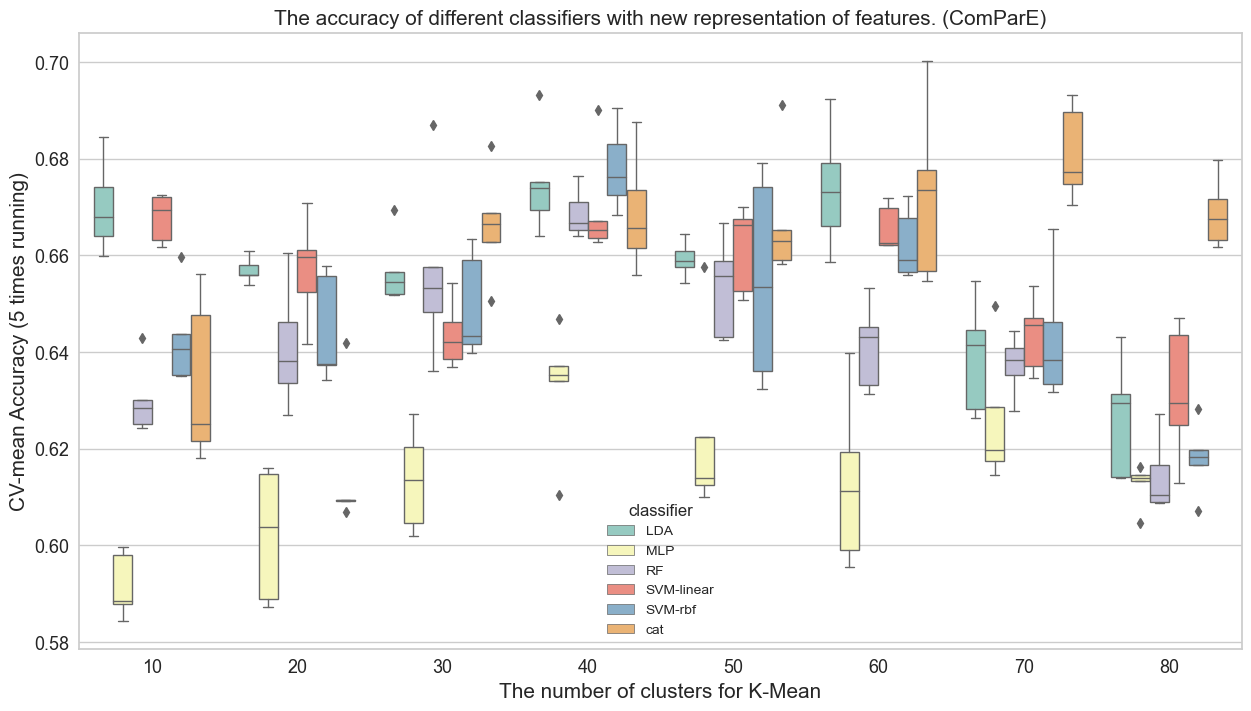

In [166]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="k", y="cv_mean_acc", hue="classifier", data=grouped_multiple,palette="Set3",linewidth=1)
ax.axes.set_title("The accuracy of different classifiers with new representation of features. ({})".format(feature_set),fontsize=15)
ax.set_xlabel("The number of clusters for K-Mean",fontsize=15)
ax.set_ylabel("CV-mean Accuracy (5 times running)",fontsize=15)
ax.tick_params(labelsize=13)
plt.show()

save_path = './data/data_ml/{}'.format(feature_set)
for k in [20]:
    for times in range(1):
        for clf_type in ['']:
            with h5py.File('./data/data_ml/{}/dataset_{}.h5'.format(feature_set, k), 'r') as f:
                X_ = f['X'][:]
                y_ = f['y'][:]

            df_res = pd.DataFrame(columns=['feature_set','clf_type','k','times','cv','acc','recall-c','recall-a','pre-c','pre-a'])
            df_res, id_list_pre, all_y_pre,y_pre_proba_res,y_true_ = train_loop(clf_type, clfs, df_res,feature_set,k,times)

            res_out = {'id_list_pre':id_list_pre, 'all_y_pre':all_y_pre, 'y_pre_proba_res':y_pre_proba_res, 'y_true_':y_true_}
            df_res.to_csv(os.path.join(save_path,'all_results.csv'))
            #np.save( os.path.join(save_path, '{}_{}_{}'.format(times, k, clf_type)), res_out)

In [167]:
best = grouped_multiple.groupby(['classifier']).apply(lambda x: x.sort_values(['cv_mean_acc'], ascending = False))
best_all = pd.DataFrame()
for i in list(dict.fromkeys(best.classifier.values)):
    tem = best[best['classifier']==i].head(1)
    best_all = best_all.append(tem)

___________

In [168]:
best_all.reset_index(drop=True, inplace=True)
best_all = best_all.sort_values(['cv_mean_acc'], ascending=False)

In [169]:
best_all = best_all.reset_index()

In [170]:
best_all

index  classifier  times   k  cv_mean_acc
0      5         cat      8  60     0.700241
1      0         LDA      6  40     0.693158
2      4     SVM-rbf      9  40     0.690384
3      3  SVM-linear      1  40     0.690058
4      2          RF      4  30     0.686889
5      1         MLP      9  50     0.657496

In [195]:
row = best_all
rank = 2
f_name = save_path+'/{}_{}_{}.npy'.format(row.times[rank],row.k[rank],row.classifier[rank])
print(f_name)
res_hist = np.load(f_name,allow_pickle=True)

./data/data_ml/ComParE_2/9_40_SVM-rbf.npy


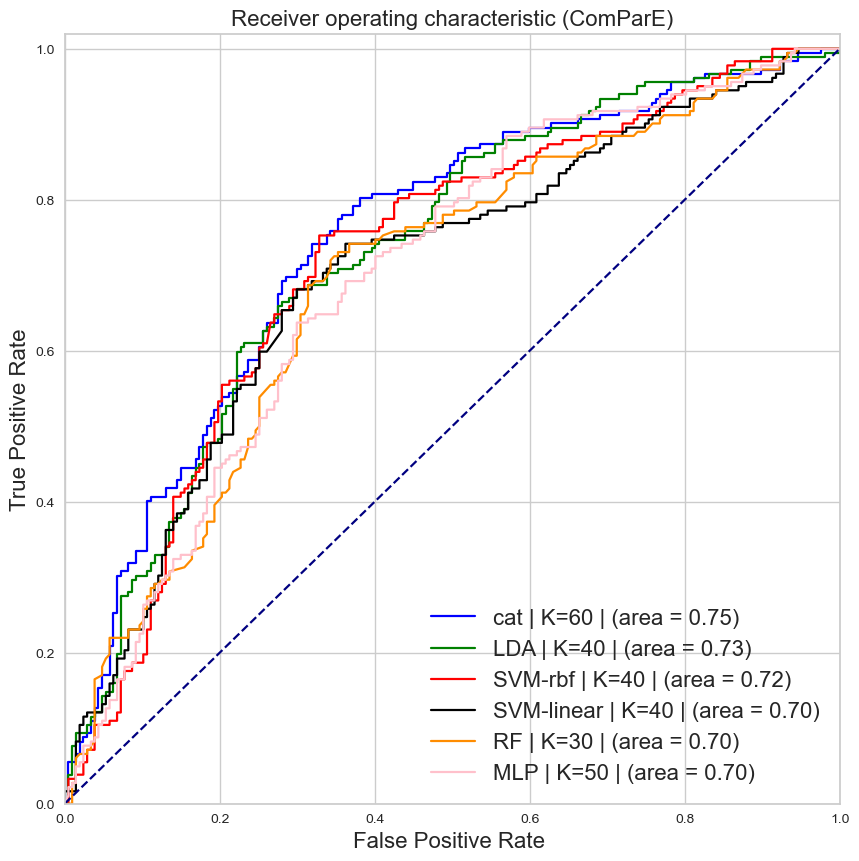

In [173]:
from sklearn import metrics
plt.figure(figsize=(10,10))
lw = 1.6
row = best_all
c = ['blue','green','red','black','darkorange','pink']
for i in range(6):
    res_hist = np.load(save_path+'/{}_{}_{}.npy'.format(row.times[i],row.k[i],row.classifier[i]),allow_pickle=True)
    fpr, tpr, threshold = metrics.roc_curve(res_hist.item()['y_true_'],np.array(res_hist.item()['y_pre_proba_res'])[...,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=c[i],lw=lw, label='{} | K={} | (area = {:.2f})'.format(row.classifier[i],row.k[i],roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate ',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title(f'Receiver operating characteristic ({feature_set})',fontsize=16)
plt.legend(loc="lower right",fontsize=16)
plt.show()

In [300]:
new_list = [i.split('-')[0] for i in res_hist.item()['id_list_pre']]
new_dic = list_duplicates(new_list)
y_pre=[]
y_true=[]
all_y_pre = res_hist.item()['all_y_pre']
for key,items in new_dic:
    res = sum(all_y_pre[items])/all_y_pre[items].shape[0]
    y = np.array(res_hist.item()['y_true_'])[items]
    y_true.append(y[0])
    if res > 0.5:y_pre.append(1)
    else: y_pre.append(0)
print(classification_report(y_true, y_pre, target_names=['Control', 'AD'],labels=[0,1]) )

              precision    recall  f1-score   support

     Control       0.64      0.85      0.73        78
          AD       0.82      0.60      0.70        93

    accuracy                           0.71       171
   macro avg       0.73      0.72      0.71       171
weighted avg       0.74      0.71      0.71       171



In [301]:
df_pre_dis = pd.DataFrame(columns=['id','y_true','y_pre','age','gender'])
new_list = [i.split('-')[0] for i in res_hist.item()['id_list_pre']]
new_dic = list_duplicates(new_list)
y_true = np.array(y_true)
y_pre  = np.array(y_pre)
for idx,(key,items) in enumerate(new_dic):
    tem = age_gender_by_id[int(key)]
    df_pre_dis = df_pre_dis.append({'id':key,'y_true':int(y_true[idx]),'y_pre':int(y_pre[idx]),'age':tem[0],'gender':tem[1]},ignore_index=True)

In [302]:
df_pre_dis['correct prediction'] = 1-abs(df_pre_dis.y_true - df_pre_dis.y_pre)

[5.0, 10.0, 13.0, 16.0, 12.0, 6.0, 0.0, 2.0, 6.0, 6.0, 7.0, 2.0]


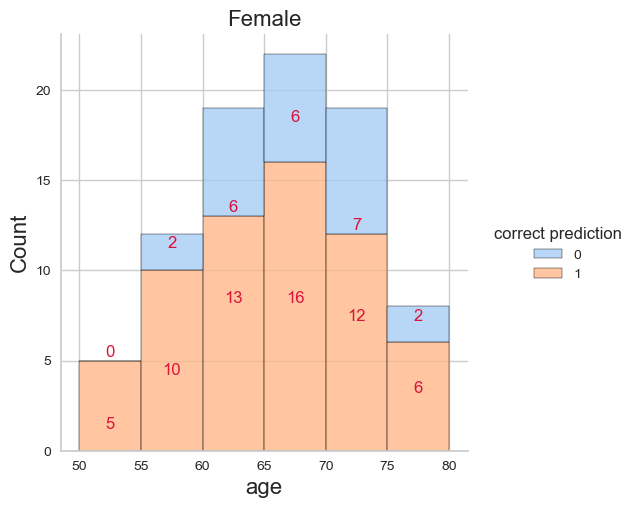

In [303]:
df_tem = df_pre_dis[df_pre_dis.gender==0]
g = sns.displot(df_tem, x="age",hue='correct prediction',bins=6, binrange =(50,80),
            multiple="stack",kde=False, palette="pastel").set(title='Female')
ax=g.ax #annotate axis = seaborn axis

h = []
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    h.append(height)
print(h)
ann = [5.0, 10.0, 13.0, 16.0, 12.0, 6.0, 0.0, 2.0, 6.0, 6.0, 7.0, 2.0]
h   = [1.0, 4.0, 8.0, 8.0, 7.0, 3.0, 5.0, 11.0, 13.0, 18.0, 12.0, 7.0]
for idx, p in enumerate(ax.patches):
    ax.annotate(f'{ann[idx]:.0f}\n',
                (p.get_x() + p.get_width() / 2, h[idx]), ha='center', va='center', color='crimson')
plt.show()


[4.0, 8.0, 15.0, 16.0, 16.0, 1.0, 1.0, 4.0, 4.0, 6.0, 4.0, 7.0]


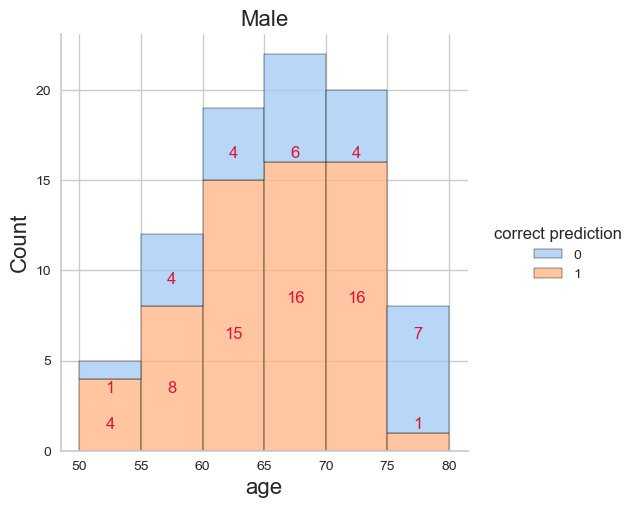

In [294]:
df_tem = df_pre_dis[df_pre_dis.gender==1]
b = sns.displot(df_tem, x="age",hue='correct prediction',bins=6, binrange =(50,80),
            multiple="stack", palette="pastel").set(title='Male')

ax=b.ax

h1 = []
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    h1.append(height)
print(h1)
ann1 =  [4.0, 8.0, 15.0, 16.0, 16.0, 1.0, 1.0, 4.0, 4.0, 6.0, 4.0, 7.0]
h1   =  [1.0, 3.0, 6.0, 8.0, 8.0, 1.0, 3.0, 9.0, 16.0, 16.0, 16.0, 6.0]
for idx, p in enumerate(ax.patches):
    ax.annotate(f'{ann1[idx]:.0f}\n',
                (p.get_x() + p.get_width() / 2, h1[idx]), ha='center', va='center', color='crimson')
plt.show()

In [169]:
h1

[3.0, 9.0, 12.0, 12.0, 9.0, 5.0, 2.0, 3.0, 7.0, 10.0, 11.0, 3.0]

In [299]:
new_list = [i.split('-')[0] for i in res_hist.item()['id_list_pre']]
new_dic = list_duplicates(new_list)
y_pre=[]
y_true=[]
all_y_pre = res_hist.item()['all_y_pre']
for key,items in new_dic:
    y = np.array(res_hist.item()['y_true_'])[items]
    #print(key, items, all_y_pre[items],y[0] )
    y_true.append(y[0])
    correct = all_y_pre[items][all_y_pre[items]==y[0]]
    #print(key,items,correct, y[0])
    ratio = correct.shape[0]/ all_y_pre[items].shape[0]
    if ratio > 0.5: y_pre.append(y[0])
    else: y_pre.append(1-y[0])

print(classification_report(y_true, y_pre, target_names=['Control', 'AD'],labels=[0,1]) )

              precision    recall  f1-score   support

     Control       0.60      0.71      0.65        78
          AD       0.71      0.60      0.65        93

    accuracy                           0.65       171
   macro avg       0.65      0.65      0.65       171
weighted avg       0.66      0.65      0.65       171



new_dic = list_duplicates(new_list)
tem_f = get_f_name('./data/audio/Pitt/Dementia/')
tem_f_ad = [i.split('-')[0] for i in tem_f]
id_ad_ = list(dict.fromkeys(tem_f_ad))
y_true_ =[]
for key,items in new_dic:
    if key in id_ad_: y_true_.append(1)
    else : y_true_.append(0)

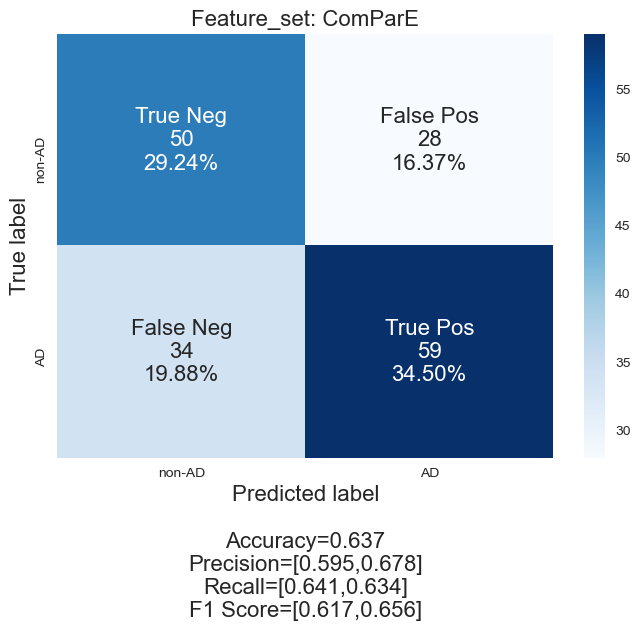

In [157]:
from lib.cf_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['non-AD', 'AD']
cf_matrix = cf_matrix = confusion_matrix(y_true,y_pre)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      title = f'Feature_set: {feature_set}',
                      size=16)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16

plt.show()

In [304]:
df_new = df_pre_dis

In [305]:
df_new.id = df_new.id.apply(lambda x: int(x))

In [306]:
print([i for i in annot.columns])

['id', 'idate', 'testigo', 'year', 'yearache', 'pwml', 'basedx', 'dx1', 'dx2', 'dx3', 'changedx', 'intertdx', 'changdx2', 'possible', 'probable', 'groupdx', 'curdx1', 'curdx2', 'curdx3', 'currdx4', 'entryage', 'onsetage', 'sex', 'race', 'educ', 'mmsegrp', 'mms', 'mattis', 'cdrfs', 'blessed', 'hamilton', 'htotal', 'hmtotal', 'nyu', 'ddate', 'psychot1', 'visit2da', 'hamilt2', 'hrs2tota', 'hrs2m', 'cdr2', 'bless2', 'nyu2', 'cerad2', 'mmse2', 'mattis2', 'visit3', 'hamilt3', 'hrs3tota', 'hrs3m', 'cdr3', 'bless3', 'nyu3', 'cerad3', 'mmse3', 'mattis3', 'visit4', 'hamilt4', 'hrs4tota', 'hrs4m', 'cdr4', 'bless4', 'nyu4', 'cerad4', 'mmse4', 'mattis4', 'visit5', 'hamilt5', 'hrs5tota', 'hrs5m', 'cdr5', 'bless5', 'nyu5', 'cerad5', 'mmse5', 'mattis5', 'visit6', 'hamilt6', 'hrs6tota', 'hrs6m', 'cdr6', 'bless6', 'nyu6', 'cerad6', 'mmse6', 'mattis6', 'visit7', 'hamilt7', 'hrs7tota', 'hrs7mo', 'cdr7', 'blessed7', 'nyu7', 'cerad7', 'mmse7', 'mattis7', 'lastdate', 'lastdx', 'lhamilto', 'lasthrs', 'lastcdr

In [307]:
df_edu = annot[annot['id'].isin(df_new['id'])][['id','dx1']]

In [309]:
df_new_edu = pd.merge(df_new, df_edu, how='inner', left_on = 'id', right_on = 'id')

In [310]:
df_tem = df_new_edu[df_new_edu.y_true ==1]
g = sns.displot(df_tem, x="dx1",hue='correct prediction',bins=7,binrange =(100,800),
            multiple="stack",kde=False, palette="pastel")
ax=g.ax #annotate axis = seaborn axis
plt.show()

In [311]:
annot

id       idate  testigo  year  yearache  pwml  basedx  dx1    dx2  dx3  \
0      1  1983-07-29        1     0         0   0.0       1  100    NaN  NaN   
1      2  1983-08-17        1     0         0   NaN       8  800   -2.0 -2.0   
2      3  1983-08-25        1     0         0   0.0       1  100    NaN  NaN   
3      5  1983-08-23        1     0         0   0.0       1  100  730.0  NaN   
4      6  1983-08-26        1     0         0   NaN       8  800   -2.0 -2.0   
..   ...         ...      ...   ...       ...   ...     ...  ...    ...  ...   
287  705  1988-02-09        1     0         0   0.0       1  100   -2.0 -2.0   
288  707  1988-02-18        1     0         0   NaN       2  210   -2.0 -2.0   
289  709  1988-02-11        1     0         0   NaN       8  820   -2.0 -2.0   
290  711  1988-02-25        1     0         0   NaN       2  211   -2.0 -2.0   
291  714  1988-03-08        1     0         0   NaN       2  210   -2.0 -2.0   

     ...    lastdate  lastdx lhamilto  lasthrs  lastcdr  lastnyu  eps  \
0    ...  1986-08-12     NaN      NaN      0.0      3.0      5.0  NaN   
1    ...  2006-05-16   800.0      NaN      1.0      0.0      NaN  NaN   
2    ...  1985-11-07     NaN     10.0      2.0      3.0      NaN  NaN   
3    ...  1985-09-05     NaN     18.0      1.0      1.0     34.0  NaN   
4    ...  1998-10-15   800.0      NaN      2.0      0.0      0.0  NaN   
..   ...         ...     ...      ...      ...      ...      ...  ...   
287  ...  1991-03-20   100.0     17.0      1.0      3.0     30.0  NaN   
288  ...  1991-04-05     NaN      0.0      5.0      2.0      2.0  NaN   
289  ...  1989-02-21   820.0      2.0      3.0      0.0      0.0  NaN   
290  ...  1990-03-08   210.0      2.0     10.0      1.0      8.0  NaN   
291  ...  1990-06-06     NaN      NaN      9.0      3.0     45.0  NaN   

     lastmms  lamattis  lastbless  
0       11.0       NaN       15.0  
1       28.0       NaN        NaN  
2        5.0       NaN        NaN  
3       19.0       NaN        4.0  
4       30.0     142.0        0.0  
..       ...       ...        ...  
287      6.0       NaN       12.0  
288     15.0       NaN        7.5  
289     29.0     142.0        0.5  
290     21.0     113.0        3.5  
291      7.0      37.0       12.5  

[292 rows x 106 columns]